In [1]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.manifold import TSNE
from tqdm.notebook import tqdm
from numba import njit
from functools import lru_cache

In [2]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [3]:
plt.style.use('seaborn-whitegrid')
rcParams['font.size'] = 18
rcParams['figure.figsize'] = (12, 8)
color_list = ['#19274D', '#C34798', '#FF670F', '#FAC800', '#65AF41']
cmap_bold = ListedColormap(color_list)
cmap_light = LinearSegmentedColormap.from_list('mylight', colors=color_list)

In [4]:
digits, digit_class = load_digits(return_X_y=True)
X = digits

In [91]:

@lru_cache(maxsize=None)
def distance_pair(i, j):
  
    return np.linalg.norm(X[i,:] - X[j,:])
    
@lru_cache(maxsize=None)
def distance_all(i):
    return np.linalg.norm(X[i,:] - np.delete(X, i, axis=0), axis=1)

def entropy(asym_affinities, eps=1e-12):
    """
    Shannon entropy of pairwise affinity
    """
    asym_affinities = np.clip(asym_affinities, eps, None) # Some are so small that log2 fails.
    return - np.sum(asym_affinities * np.log2(asym_affinities))


def perplexity(asym_affinities):
    return 2**entropy(asym_affinities)


def get_pairwise_affinities(i, X, perp, tol):
    """
    Returns sigma and pji affinities for a specific value of i which
    corresponds to perp, the desired perplexity.
    
    Output Shape: Sigma is scalar, pji is 1xm asym affinities
    """
    #sigma, i_asym_affinities = - np.inf, np.zeros(X.shape[0])
    
    # Element-wise min and max, the "corners" of the diagonal of an enclosing orthotope around the data.
    x_min = np.min(X, axis=0)
    x_max = np.max(X, axis=0)

    sigma_max = np.linalg.norm(x_max - x_min)
    sigma_min = 1e-12
    
    while (sigma_max - sigma_min) > tol: # May need near check as it's float
        sigma = (sigma_min + sigma_max) / 2
        i_asym_affinities = row_pairwise_affinities(i, X, sigma)
        current_perp = perplexity(i_asym_affinities)
        if current_perp == perp:
            break
        if current_perp > perp:
            sigma_max = sigma
        elif current_perp < perp:
            sigma_min = sigma
        
    return sigma, i_asym_affinities
    
def row_pairwise_affinities(i, X, sigma_i):
    """
    Calculate the entire conditional distribution P_{j|i} for all j,
    for a specified i and sigma.
    
    Output shape: 1xm, 0 at i == j.
    """
    asym_affinities = np.empty(X.shape[0], dtype=np.float64)
    for j in range(X.shape[0]):
        asym_affinities[j] = pairwise_affinity(i, j, X, sigma_i)
        
    return asym_affinities
    

    
def all_pairwise_sym_affinities(X, perp, tol):
    """
    Calculate the entire symmetric distribution P for a specified and sigmas.
    TODO: takes a while
    Output shape: mxm.
    """
    m, n = X.shape
    pairwise_affin_mat = np.zeros((m,m))
    for i  in tqdm(range(m), "sym affinity"):
        _, pairwise_affin_mat[i,:] = get_pairwise_affinities(i, X, perp, tol)
        pass
    
    sym_affinities = (pairwise_affin_mat + pairwise_affin_mat.T)/(2*m)
    
    return sym_affinities



def pairwise_affinity(i, j, X, sigma_i):
    """
    Returns asymmetric affinity, p_{j|i}
    
    Output Shape: scalar
    """
    # eq 1
    if i == j: # Shortcut
        return 0
    xi = X[i,:]
    xj = X[j,:]
    numer = np.exp((-distance_pair(i,j))/(2*(sigma_i**2)))
    denom = np.exp(-distance_all(i)/(2 * sigma_i ** 2))
    denom = np.sum(denom)
    pji = (numer)/(denom)
    return pji


def low_dimensional_affinity_denom(Y):
    denom = 0
    for k in range(Y.shape[0]):
        denom += np.sum([(1 + np.linalg.norm(Y[k,:] - np.delete(Y, k, axis=0), axis=1)) ** (-1)])
        pass
    return denom

def low_dimensional_affinity(i, j, Y, q_denom):
    """
    Returns low dimensional affinity, q_{ij}
    
    Output Shape: scalar
    """
    # eq 4
    yi = Y[i,:]
    yj = Y[j,:]
    
    numer = (1 + np.linalg.norm(yi - yj)) ** (-1)
    qij = numer/q_denom
    return qij


def all_low_dimensional_affinities(Y):
    """
    Calculate the entire low dimensional affinity Q
    
    Output shape: mxm.
    """
    m = Y.shape[0]
    low_dim_affinities = np.zeros((m, m))
    q_denom = low_dimensional_affinity_denom(Y)
    for i in range(m):
        for j in range(i+1):
            low_dim_affinities[i, j] = low_dimensional_affinity(i, j, Y, q_denom)
        
    return low_dim_affinities

def compute_partial(i, P, Q, Y):
    # eq 5
    m,n = Y.shape
    partial = np.zeros(n)
    # TODO: vectorize
    for j in range(m):
        partial+=(P[i,j] - Q[i,j]) * (Y[i,:] - Y[j,:]) * (1 + np.linalg.norm(Y[i,:] - Y[j,:]))**(-1)
    
    return 4*partial


def compute_grad(P, Q, Y):
    # eq 5
    m = Y.shape[0]
    grad = np.zeros_like(Y)
    for i in range(m):
        grad[i,:] = compute_partial(i, P, Q, Y)
    return grad

In [92]:
def momentum_func(t):
    if t< 250:
        return .5
    else:
        return .8

In [93]:
def tsne(data, n_components, perp, n_iter, lr, momentum, perp_tol=1e-2):
    P = all_pairwise_sym_affinities(data, perp, perp_tol)
    init_mean = np.zeros(n_components)
    init_cov = np.identity(n_components) * 1e-4
    
    Yt = np.random.multivariate_normal(mean=init_mean, cov=init_cov, size=data.shape[0])
    Yt1 = np.zeros_like(Yt)
    for t in tqdm(range(n_iter), "iterations"):
        Yt1 = Yt
        Yt2 = Yt1
        Q = all_low_dimensional_affinities(Yt1)
        grad = compute_grad(P, Q, Yt1)
        Yt = Yt1 + lr*grad + momentum(t)*(Yt1 - Yt2)
        pass
    return Yt

In [94]:
rand_idx = np.random.choice(np.arange(digits.shape[0]), size=100, replace=False)

In [73]:
data = np.array([[3, 1],
                 [4, 1],
                 [3, 2],
                 [4, 2],
                 [2, 8],
                 [2, 9],
                 [3, 9],
                 [3, 10],
                 [9, 8],
                 [9,9],
                 [10, 9],
                 [11, 10],
                 [9, 1],
                 [9, 3],
                 [12, 4],
                 [12, 1]
                ])
classes = np.array([0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3])

In [100]:
data = digits[rand_idx,:].copy()
n_components = 2
perp = 30
n_iter = 300
lr = 100
momentum = momentum_func

In [101]:
result = tsne(data, n_components, perp, n_iter, lr, momentum, perp_tol=1e-2)

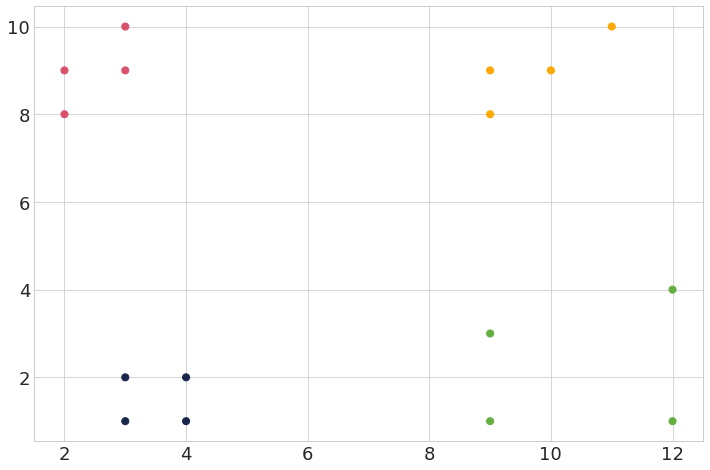

In [90]:
plt.scatter(data[:,0], data[:,1], c=classes, cmap=cmap_light, s=50)

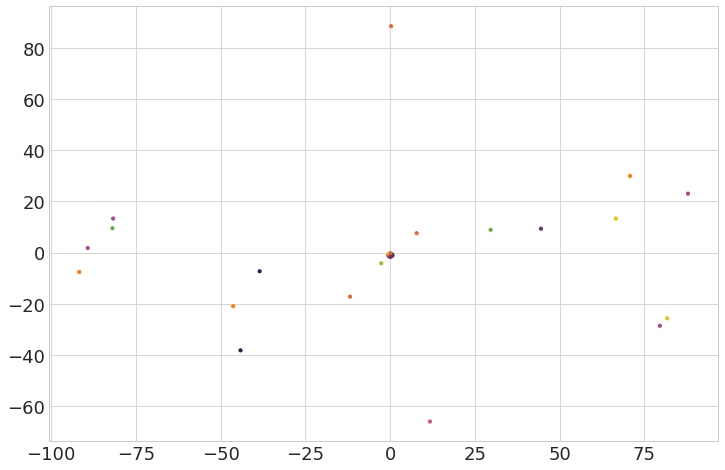

In [102]:
plt.scatter(result[:,0], result[:,1],
                    c=digit_class[rand_idx],
                     s=10,
                    cmap=cmap_light)
# plt.ylim(-2.5, -1.5)
# plt.xlim(-10, 1)

AttributeError: module 'matplotlib.pyplot' has no attribute 'set_ylim'

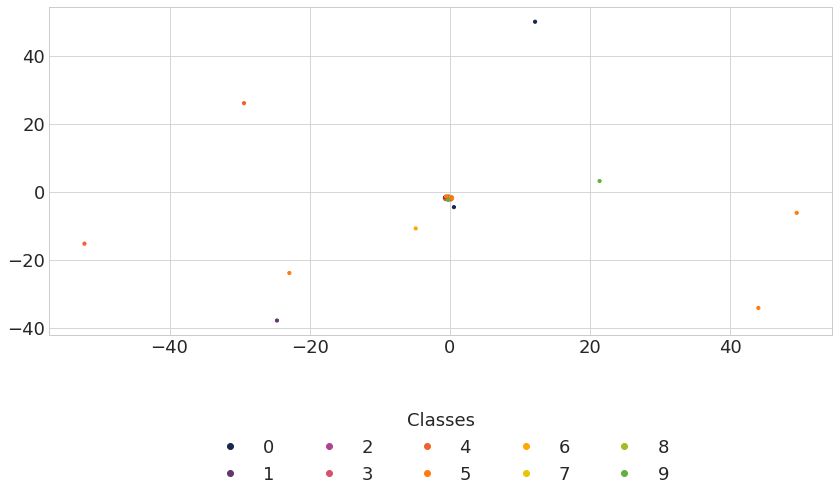

In [50]:
fig, ax = plt.subplots()
scatter = ax.scatter(result[:,0], result[:,1],
                    c=digit_class[rand_idx],
                     s=10,
                    cmap=cmap_light)
ax.legend(*scatter.legend_elements(),
            title="Classes",
            loc='lower center',
            ncol=5,
            fancybox=True,
            shadow=True,
            bbox_to_anchor=(0.5, -0.5)
            )
fig.tight_layout()
ax.set_ylim(-.5, 0)
ax.set_xlim(-.5, 0.5)
ax.axis('square')
plt.show()

# Sklearn comparison

In [78]:
tsne = TSNE(n_components=1,
            n_iter=5000,
            random_state=42,
            perplexity=3,
            n_jobs=-1)

tsne_digits = tsne.fit_transform(data)

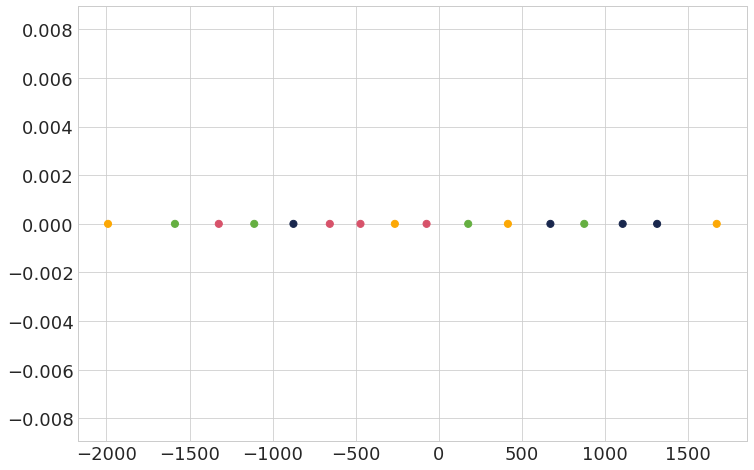

In [84]:
plt.scatter(tsne_digits[:,0], np.zeros(16),
                    c=classes,
                     s=50,
                    cmap=cmap_light)

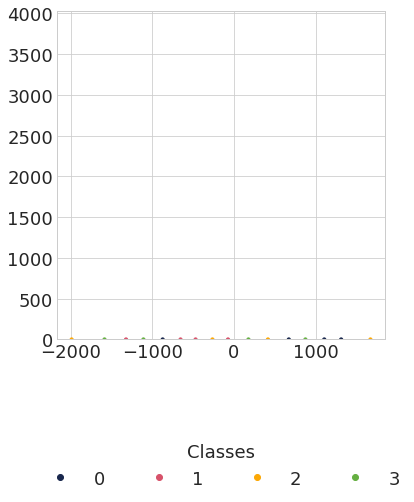

In [79]:
fig, ax = plt.subplots()
scatter = ax.scatter(tsne_digits[:,0], np.zeros(16),
                    c=classes,
                     s=10,
                    cmap=cmap_light)
ax.legend(*scatter.legend_elements(),
            title="Classes",
            loc='lower center',
            ncol=5,
            fancybox=True,
            shadow=True,
            bbox_to_anchor=(0.5, -0.5)
            )
fig.tight_layout()
ax.axis('square')
plt.show()